In [5]:
import metpy
import datetime
import rioxarray
import os
import glob
import warnings

import geopandas as gpd
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.feature as cfeature

from plotting import histogram_density_plot

save_path = '/Users/kyle/GoogleDrive/College/Graduate/Thesis/Figures and Data/tuned_models'

In [6]:
regions = gpd.read_file('data/ne_50m_admin_1_states_provinces.zip')
states = regions[regions.admin == 'United States of America']
contiguous_us = states[(states.name != 'Alaska') & (states.name != 'Hawaii')]

In [7]:
equal_area = ccrs.AlbersEqualArea(central_latitude=39.8283, central_longitude=-98.5795)
plate = ccrs.PlateCarree()

In [13]:
df = pd.read_csv('/Volumes/Shores/EPA/daily_88101_2021.csv')
df.rename({'Longitude':'longitude', 'Latitude':'latitude'}, axis=1, inplace=True)
locations = df[['latitude', 'longitude']].drop_duplicates().reset_index(drop=True)

In [19]:
def plot_locations(locations, ax, color='red', **kwargs):
    ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())

    def colorize_state(geometry):
        facecolor = (0.9375, 0.9375, 0.859375)
        return {'facecolor': facecolor, 'edgecolor': '#00000033'}

    ax.add_geometries(
        contiguous_us.geometry,
        ccrs.PlateCarree(),
        styler=colorize_state)

    ax.set_extent([-120, -72, 25, 48.8], plate)

    ax.scatter(locations.longitude, locations.latitude,
           s=4, 
           alpha=0.4, 
           c=color,
           edgecolor='black',
           transform=ccrs.PlateCarree(), 
           zorder=10, **kwargs);

    gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, alpha=0.2)
    gl.top_labels=False
    gl.right_labels=False
    xstyle = {'size': 8, 'rotation': 0, 'ha': 'center'}
    ystyle = {'size': 8, 'rotation': 0}
    gl.xlabel_style = xstyle
    gl.ylabel_style = ystyle
    ax.spines[:].set_visible(False)

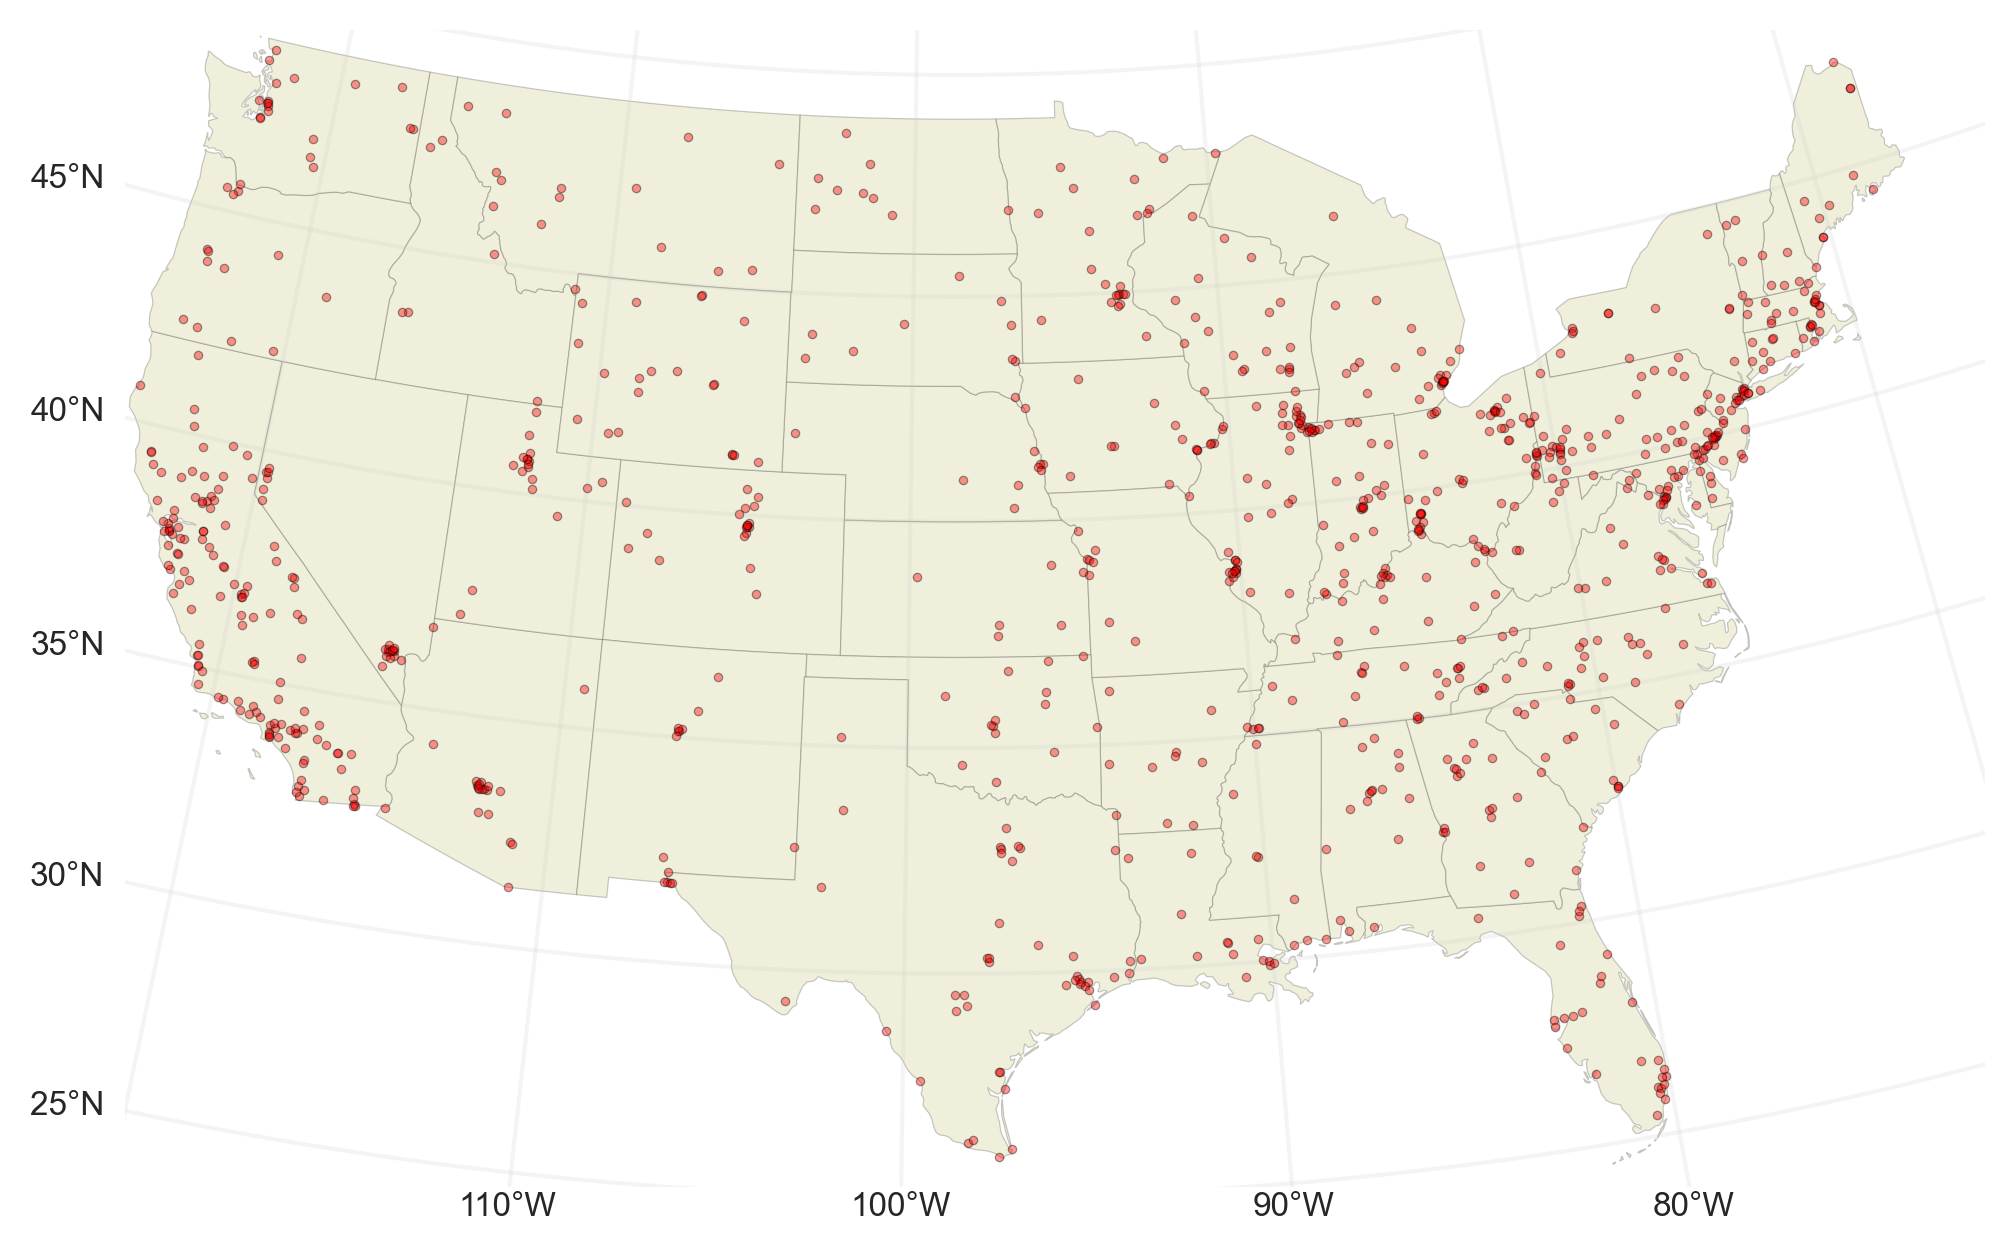

In [15]:
fig, ax = plt.subplots(dpi=300, subplot_kw=dict(projection=equal_area))
plot_locations(locations, ax=ax)

fig.savefig(f'{save_path}/epa_locations.png', format='png', bbox_inches = "tight")

In [16]:
df = pd.read_csv('data/matched/all_years_final_months.csv', parse_dates=['time'])
df.set_index('time', inplace=True)
locations2 = df.loc['2021'][['latitude', 'longitude']].drop_duplicates().reset_index(drop=True)

In [17]:
locs = pd.concat([locations,locations2]).drop_duplicates(keep=False)

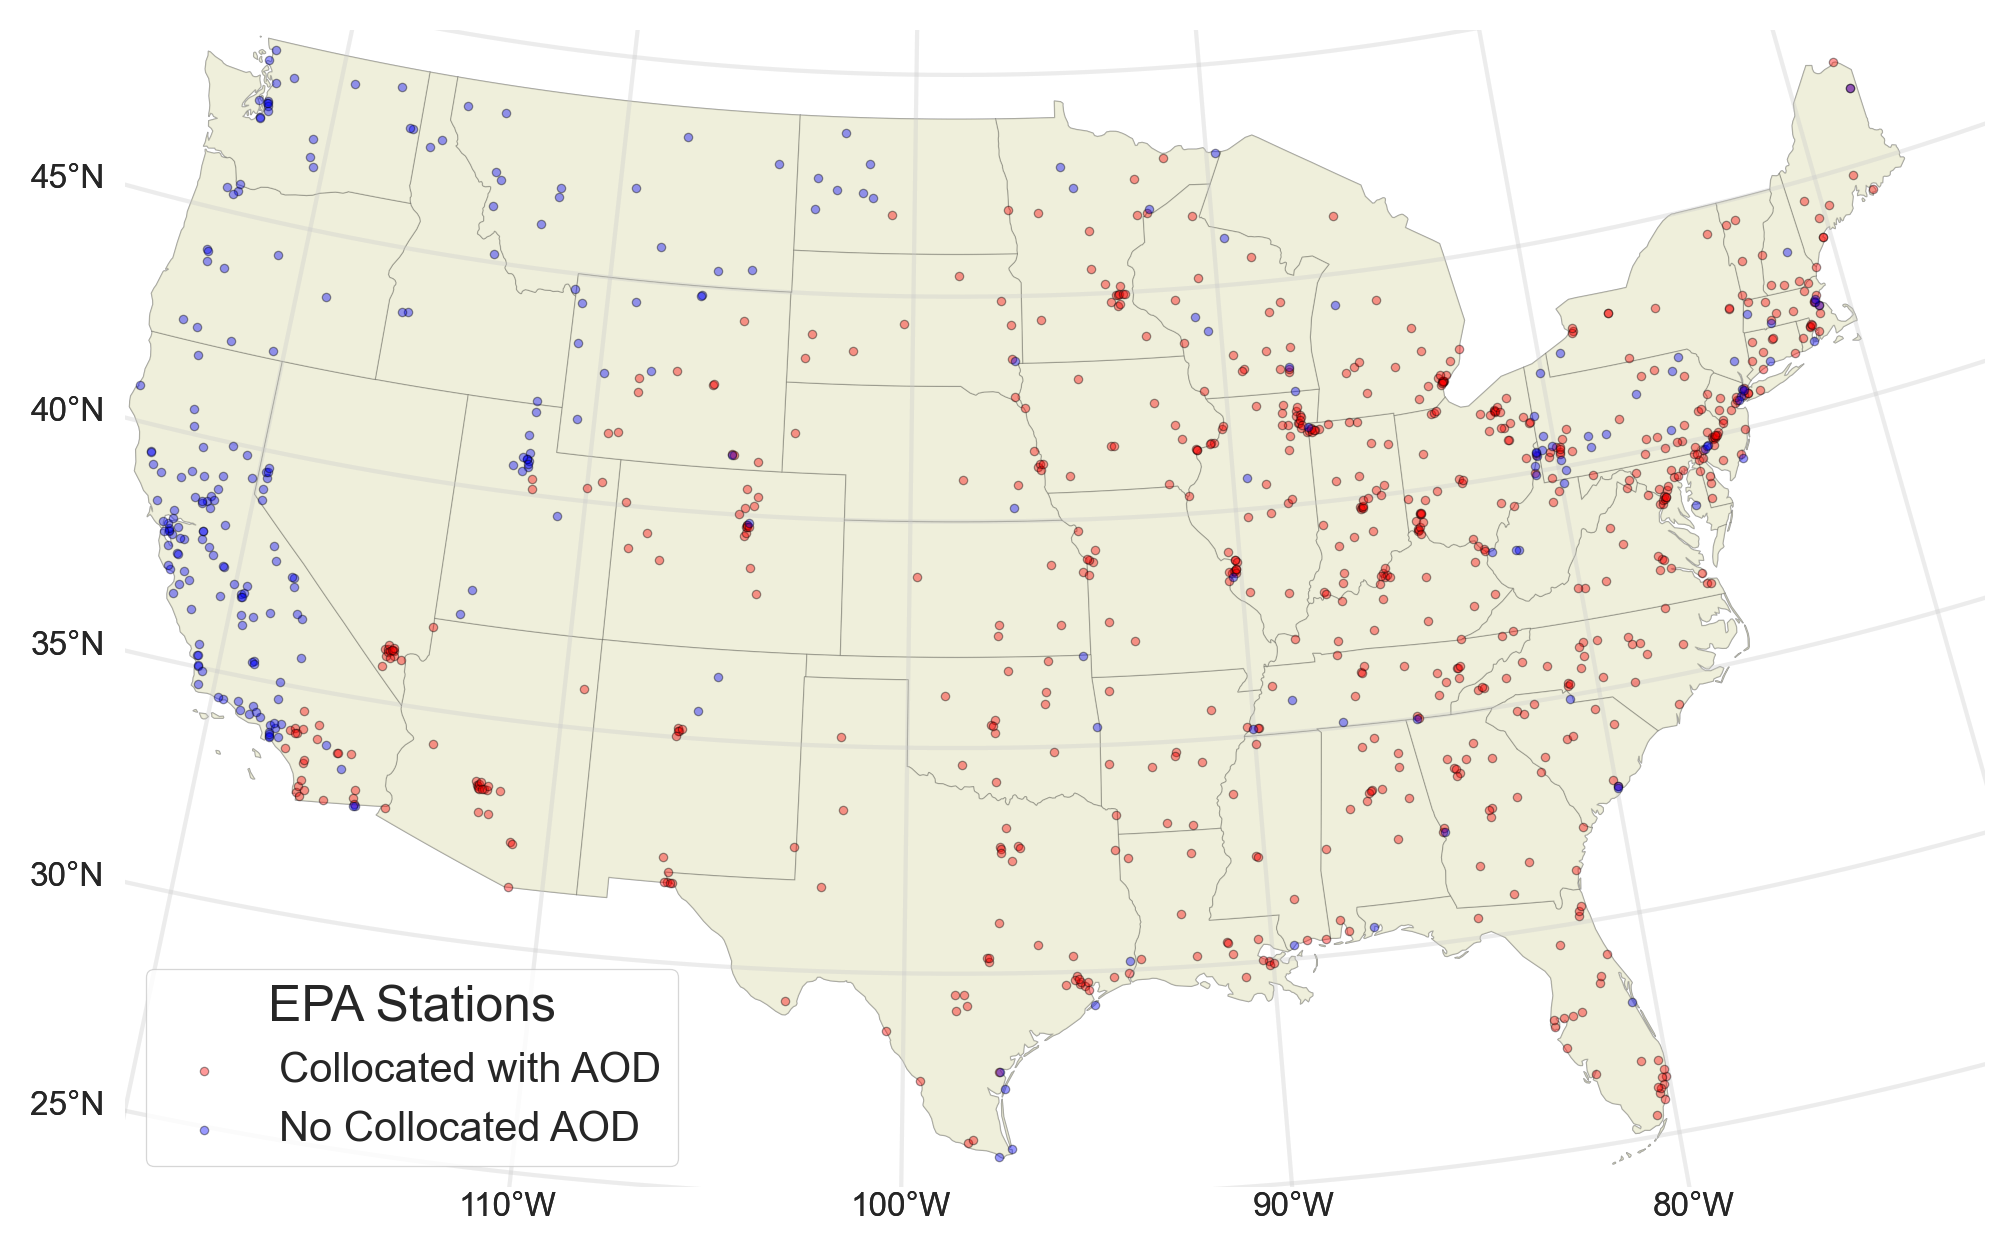

In [21]:
fig, ax = plt.subplots(dpi=300, subplot_kw=dict(projection=equal_area))
plot_locations(locations2, ax=ax, label='Collocated with AOD')
plot_locations(locs, ax=ax, color='blue', label='No Collocated AOD')

ax.legend(frameon=True, title='EPA Stations')

fig.savefig(f'{save_path}/collocated_and_uncollated_epa_locations.png', format='png', bbox_inches = "tight")

In [ ]:
df.reset_index(inplace=True)

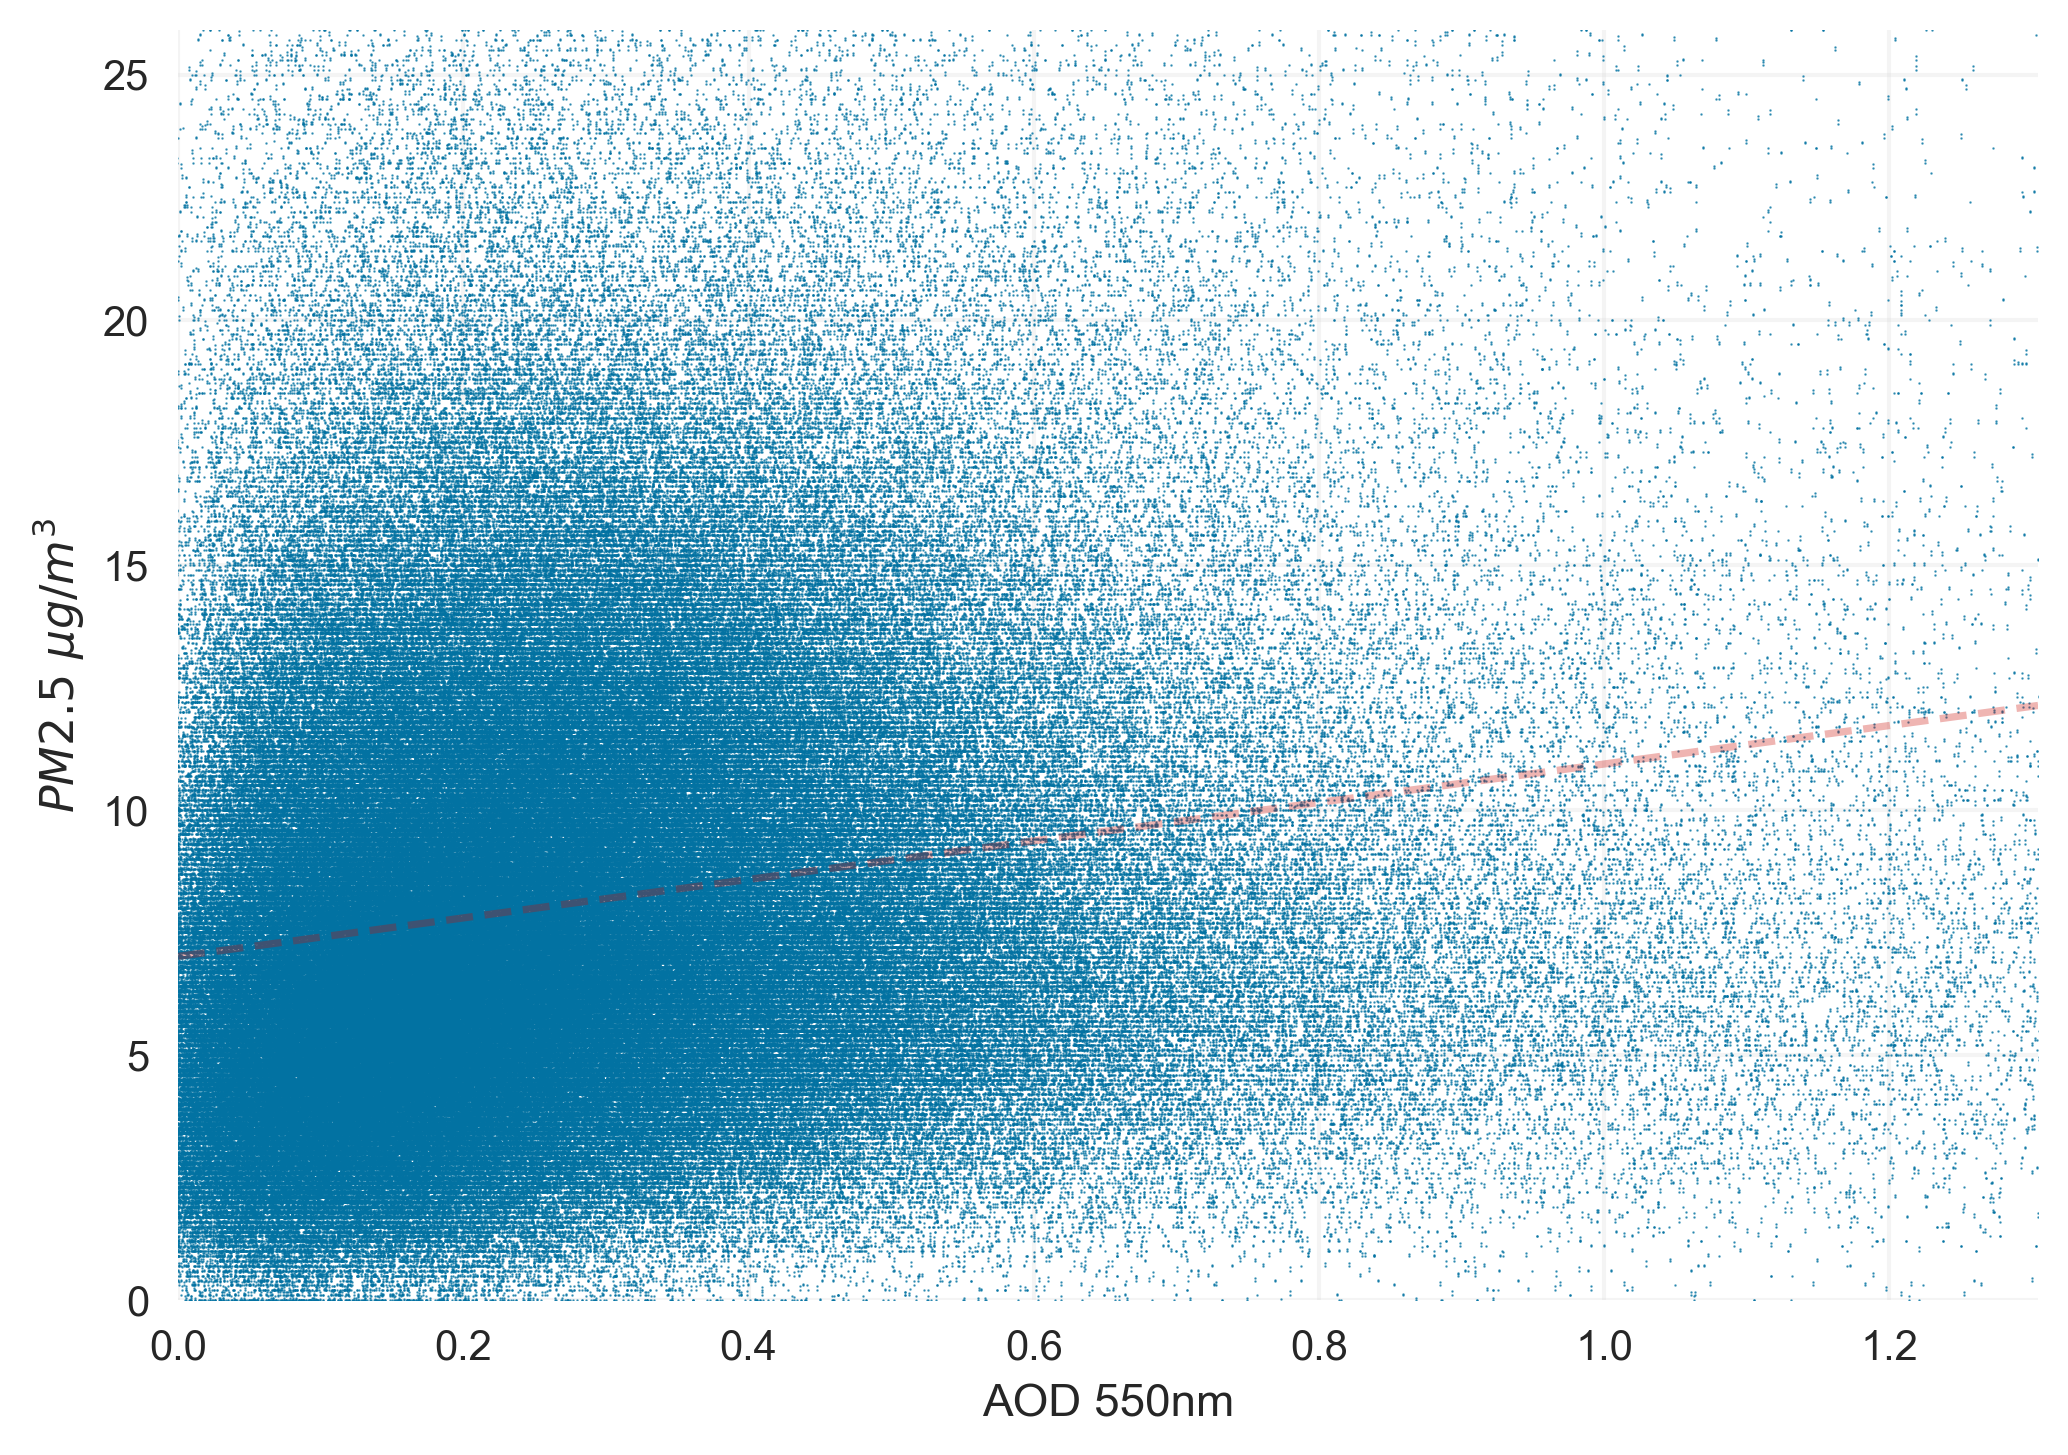

In [40]:
from sklearn.linear_model import LinearRegression
fig, ax = plt.subplots(dpi=300)

x = df.AOD
y = df.value

lin = LinearRegression().fit(x.values.reshape(-1, 1), y)

ax.scatter(x, y, s=0.1, alpha=0.6)

ax.axline(xy1=(0, lin.intercept_), slope=lin.coef_.item(), linestyle="--", color="r", alpha=0.3)

ax.set_xlim((0, np.percentile(x, 99)))
ax.set_ylim((0, np.percentile(y, 99)))

ax.set_xlabel('AOD 550nm')
ax.set_ylabel('$PM2.5~ \mu g/m^3$')

ax.tick_params(width=0)
ax.grid(alpha=0.2)
for spine in ['top', 'left', 'bottom', 'right']:
    ax.spines[spine].set_visible(False)
    
fig.savefig(f'{save_path}/aod-pm-scatter.png', format='png', bbox_inches = "tight")

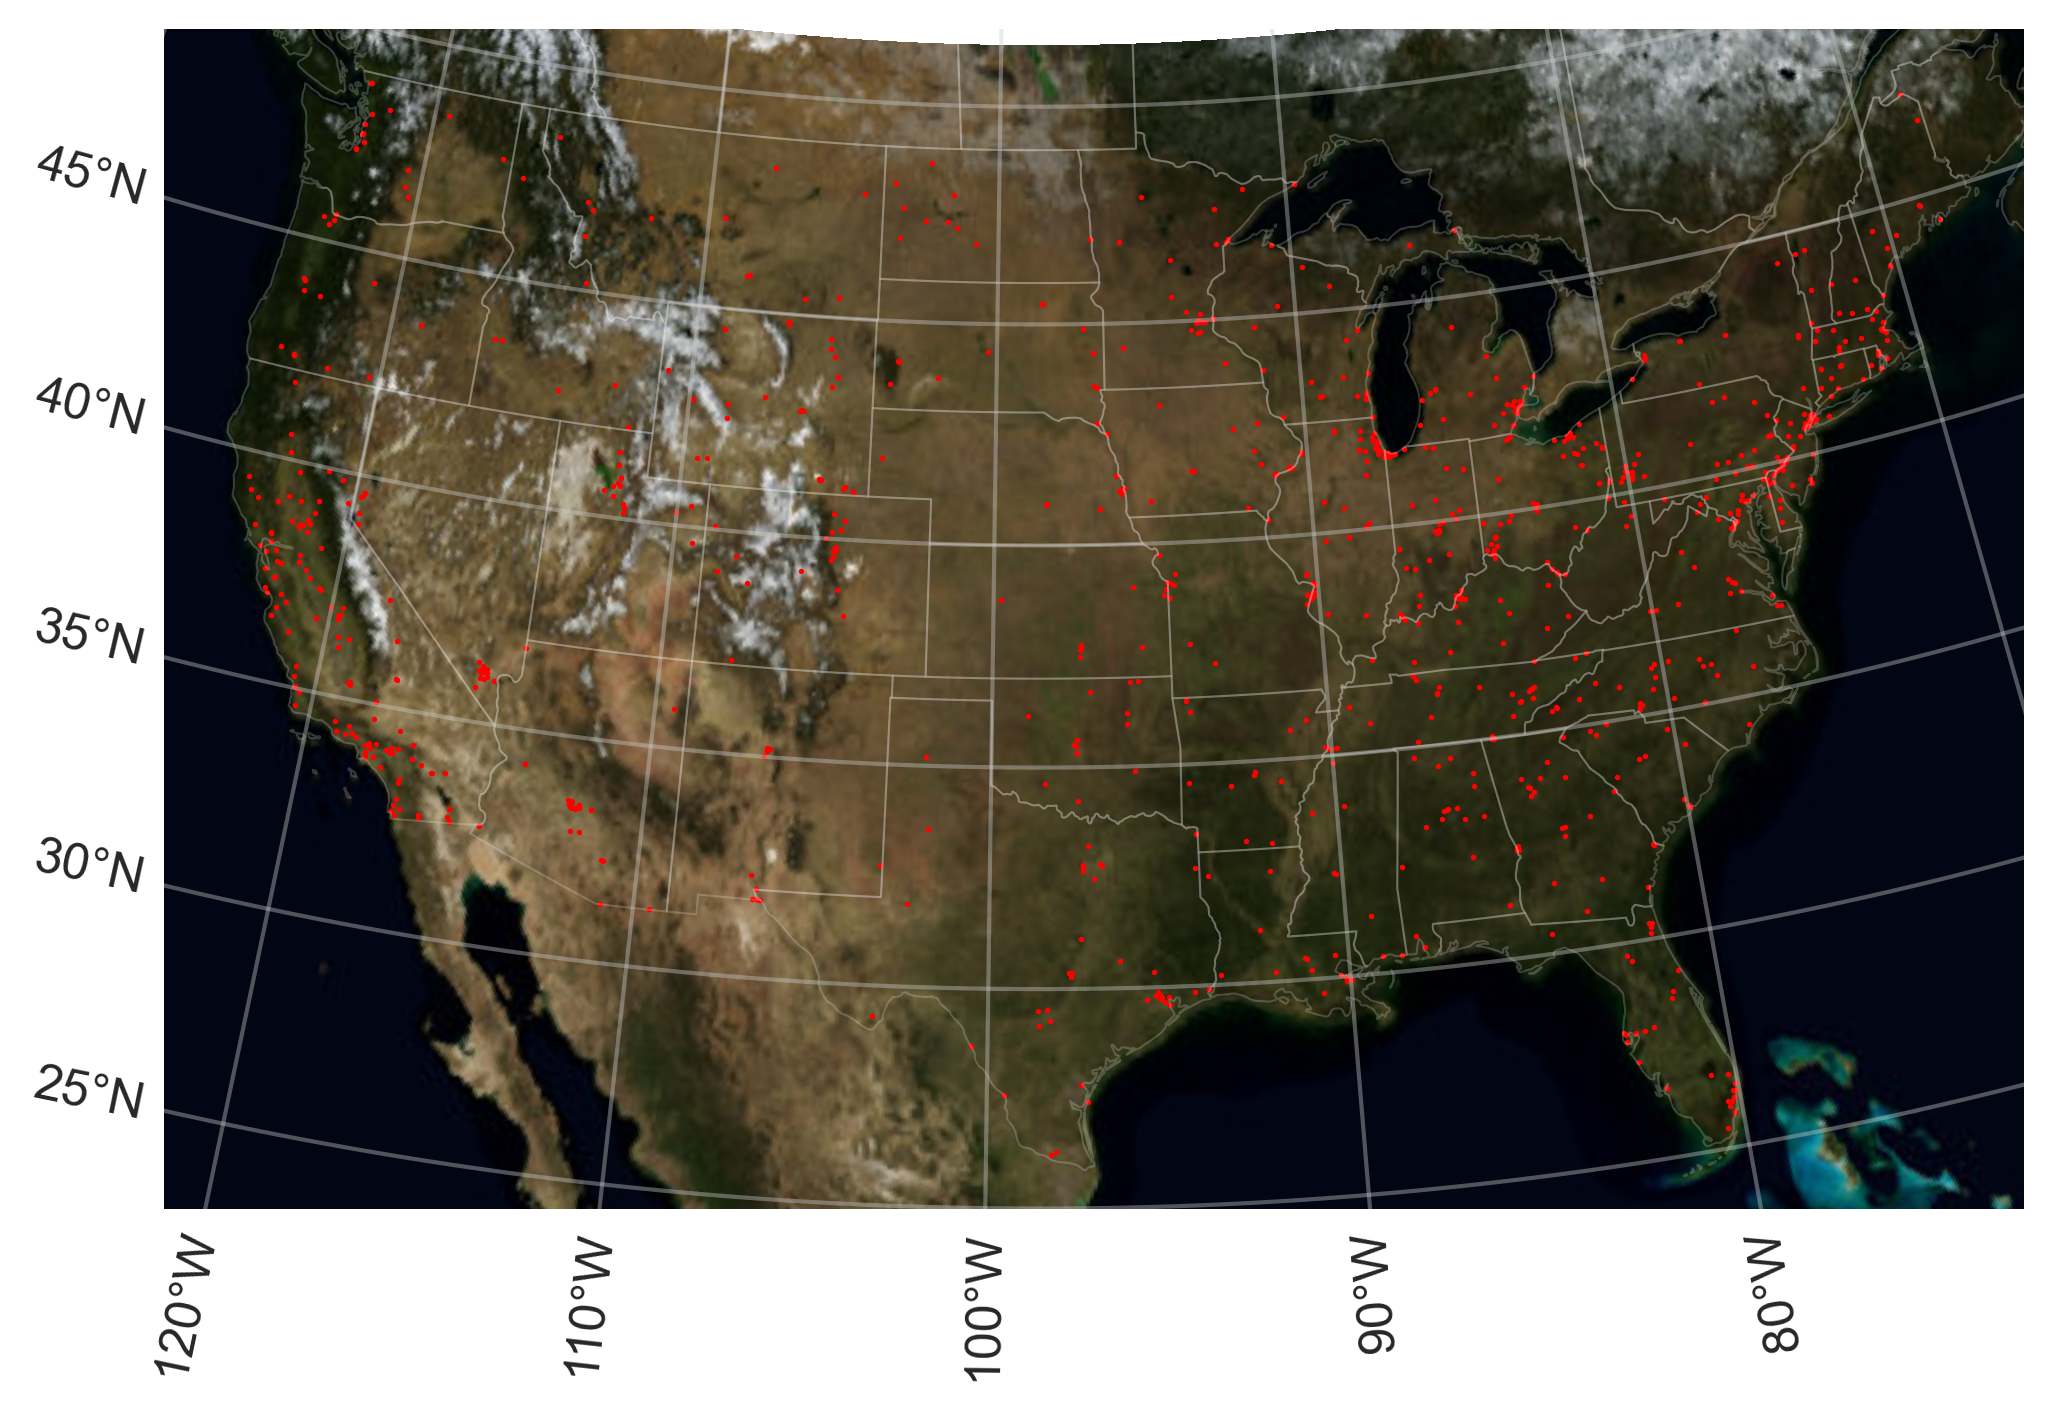

In [8]:
fig, ax = plt.subplots(dpi=300, subplot_kw={'projection': equal_area})

ax.scatter(locations.longitude, locations.latitude, 
           s=1, 
#            alpha=0.3, 
           color='red', 
           transform=plate)

# https://neo.gsfc.nasa.gov/wms/wms?version=1.3.0&service=WMS&request=GetCapabilities
ax.add_wms(wms='https://neo.gsfc.nasa.gov/wms/wms?version=1.3.0&service=WMS',
               layers=['BlueMarbleNG'])

ax.add_feature(cfeature.STATES, edgecolor='white', alpha=0.2, lw=0.5)

gl = ax.gridlines(draw_labels=True, alpha=0.4)
gl.top_labels = False
gl.right_labels = False
ax.spines['geo'].set_visible(False)

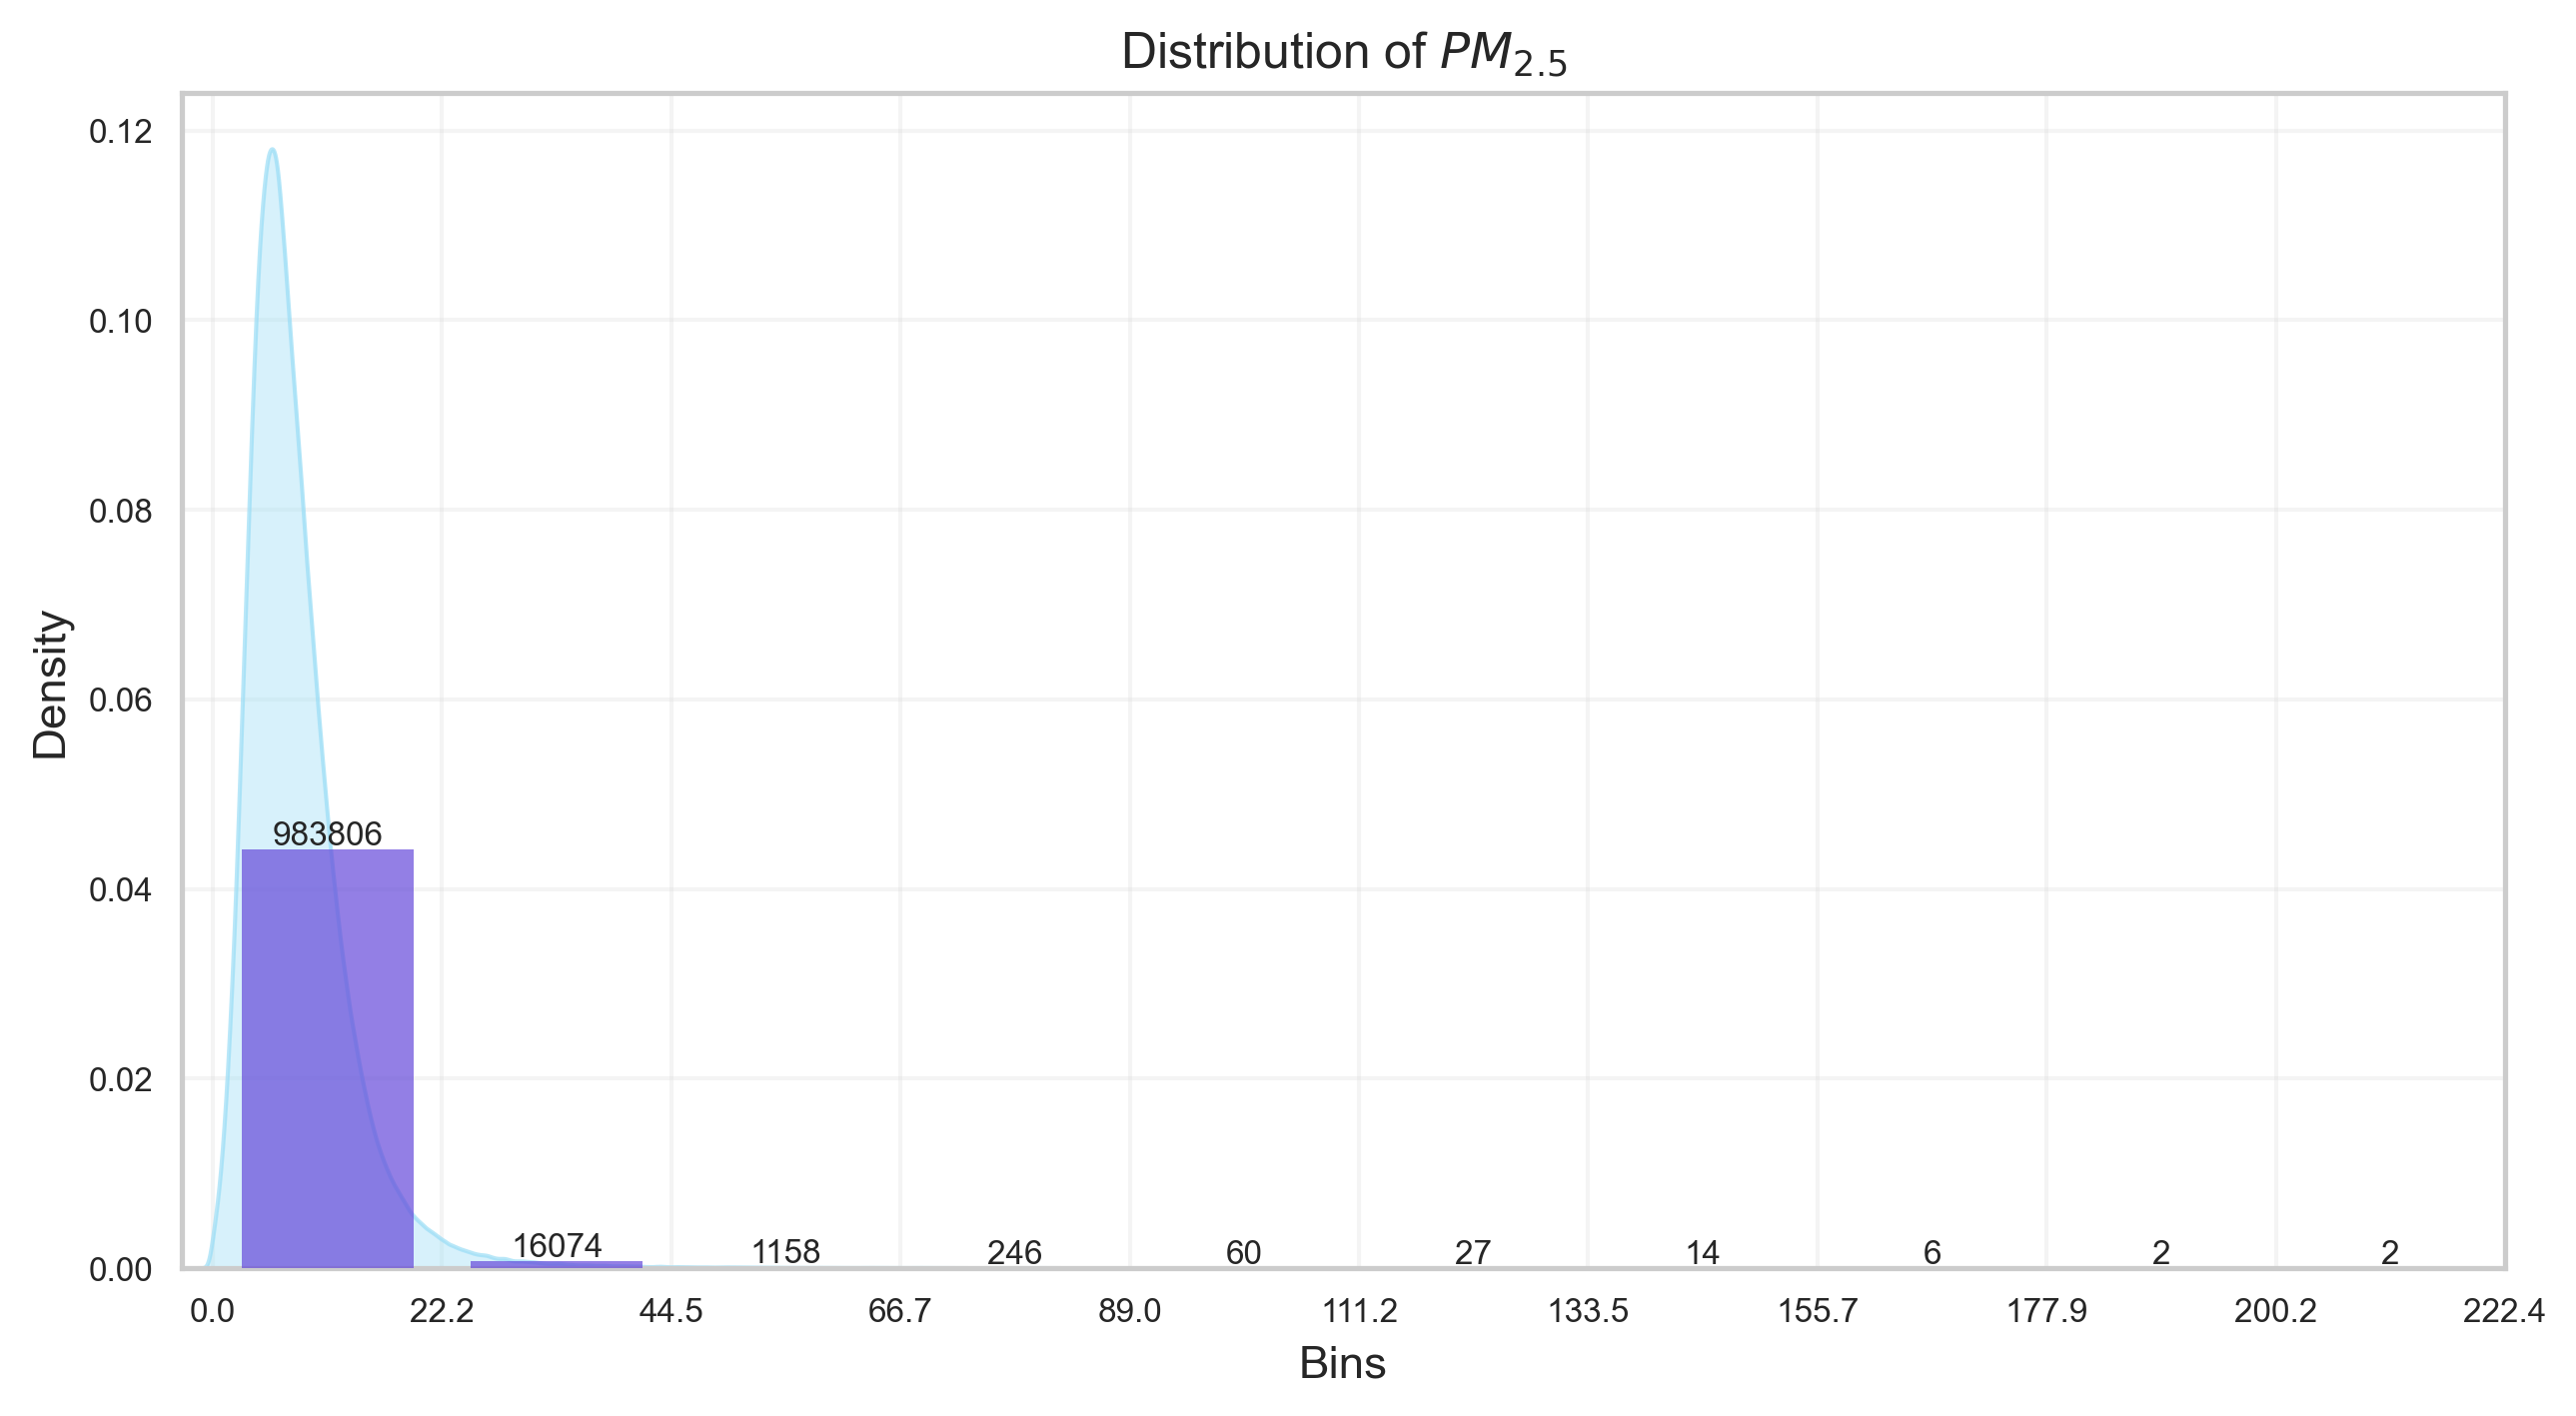

In [9]:
fig, ax = plt.subplots(dpi = 300, figsize=(10, 5.09))

bins = histogram_density_plot(df, 
                       by='value', 
                       nbins=10, 
                       title="Distribution of $PM_{2.5}$", 
                       tick_fontsize=8,
                       xlabel='Bins',
                       ylabel='Density',
                       xmin=-3, 
                       ax=ax)

# plt.savefig(os.path.join(paths.figures, 'distribution.png'))

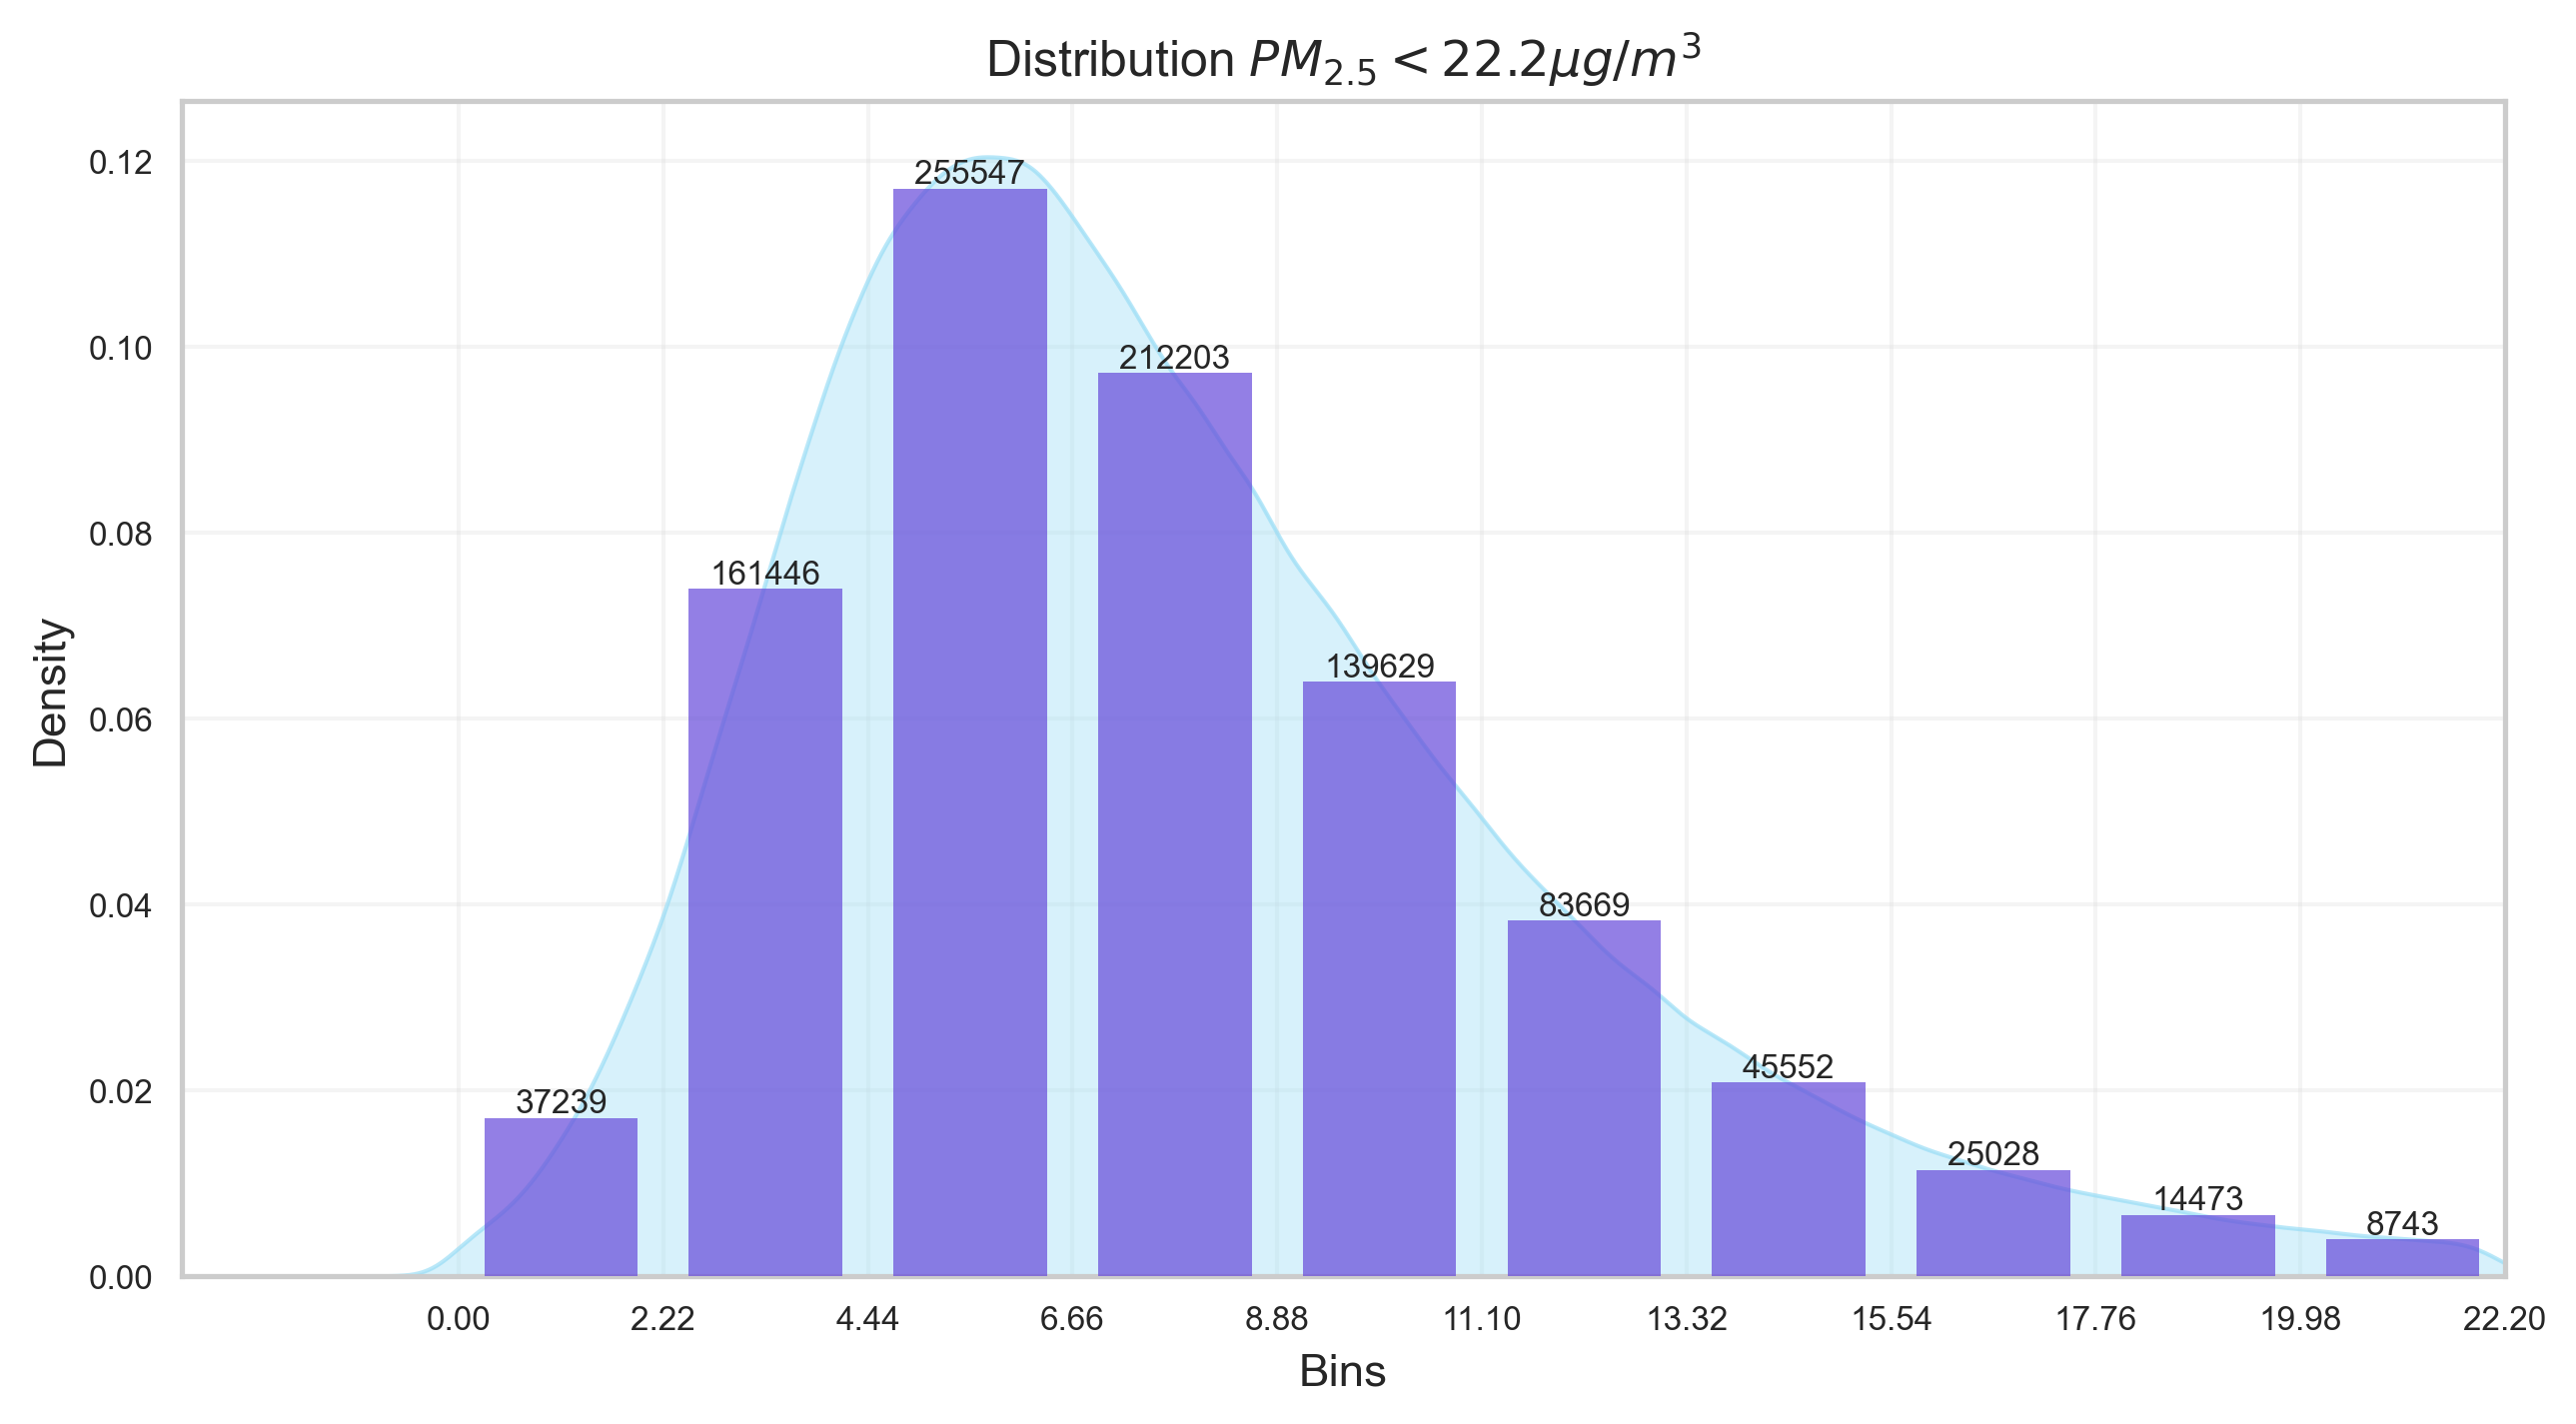

In [10]:
fig, ax = plt.subplots(dpi = 300, figsize=(10, 5.09))

bins = histogram_density_plot(df[df.value < 22.2], 
                       by='value', 
                       nbins=10, 
                       title="Distribution $PM_{2.5} < 22.2 \mu g/m^3$", 
                       tick_fontsize=8,
                       xlabel='Bins',
                       ylabel='Density',
                       xmin=-3, 
                       ax=ax)

# plt.savefig(os.path.join(paths.figures, 'distribution.png'))

In [12]:
data = df.drop(['value', 'time'] + [f'month_{i}' for i in range(1,13)], axis=1)

In [13]:
data = data[['AOD', 't2m', 'skt', 'd2m', 'tp', 'u10', 'v10', 'blh', 'sp', 'lai_hv', 'lai_lv']]

data.columns

Index(['AOD', 't2m', 'skt', 'd2m', 'tp', 'u10', 'v10', 'blh', 'sp', 'lai_hv',
       'lai_lv'],
      dtype='object')

In [14]:
data['sp'] = data['sp'] / 100

In [33]:
data.columns = [
    'AOD 550$nm$',
    '2-meter Temperature $(K)$', 
    'Skin Temperature $(K)$',
    '2-meter Dew Point $(K)$', 
    'Total Precipitation $(m)$',
    '$U_{10}~(m s^{-1})$', 
    '$V_{10}~(m s^{-1})$', 
    'Boundary Layer Height $(m)$',
    'Surface Pressure $(hPa)$',
    'Leaf area index, high veg $(m^2 m^{-2})$', 
    'Leaf area index, low veg $(m^2 m^{-2})$', 
#     'Longitude',
#     'Latitude',
#     'January',
#     'February',
#     'March',
#     'April',
#     'May',
#     'June',
#     'July',
#     'August',
#     'September',
#     'October',
#     'November',
#     'December'
]


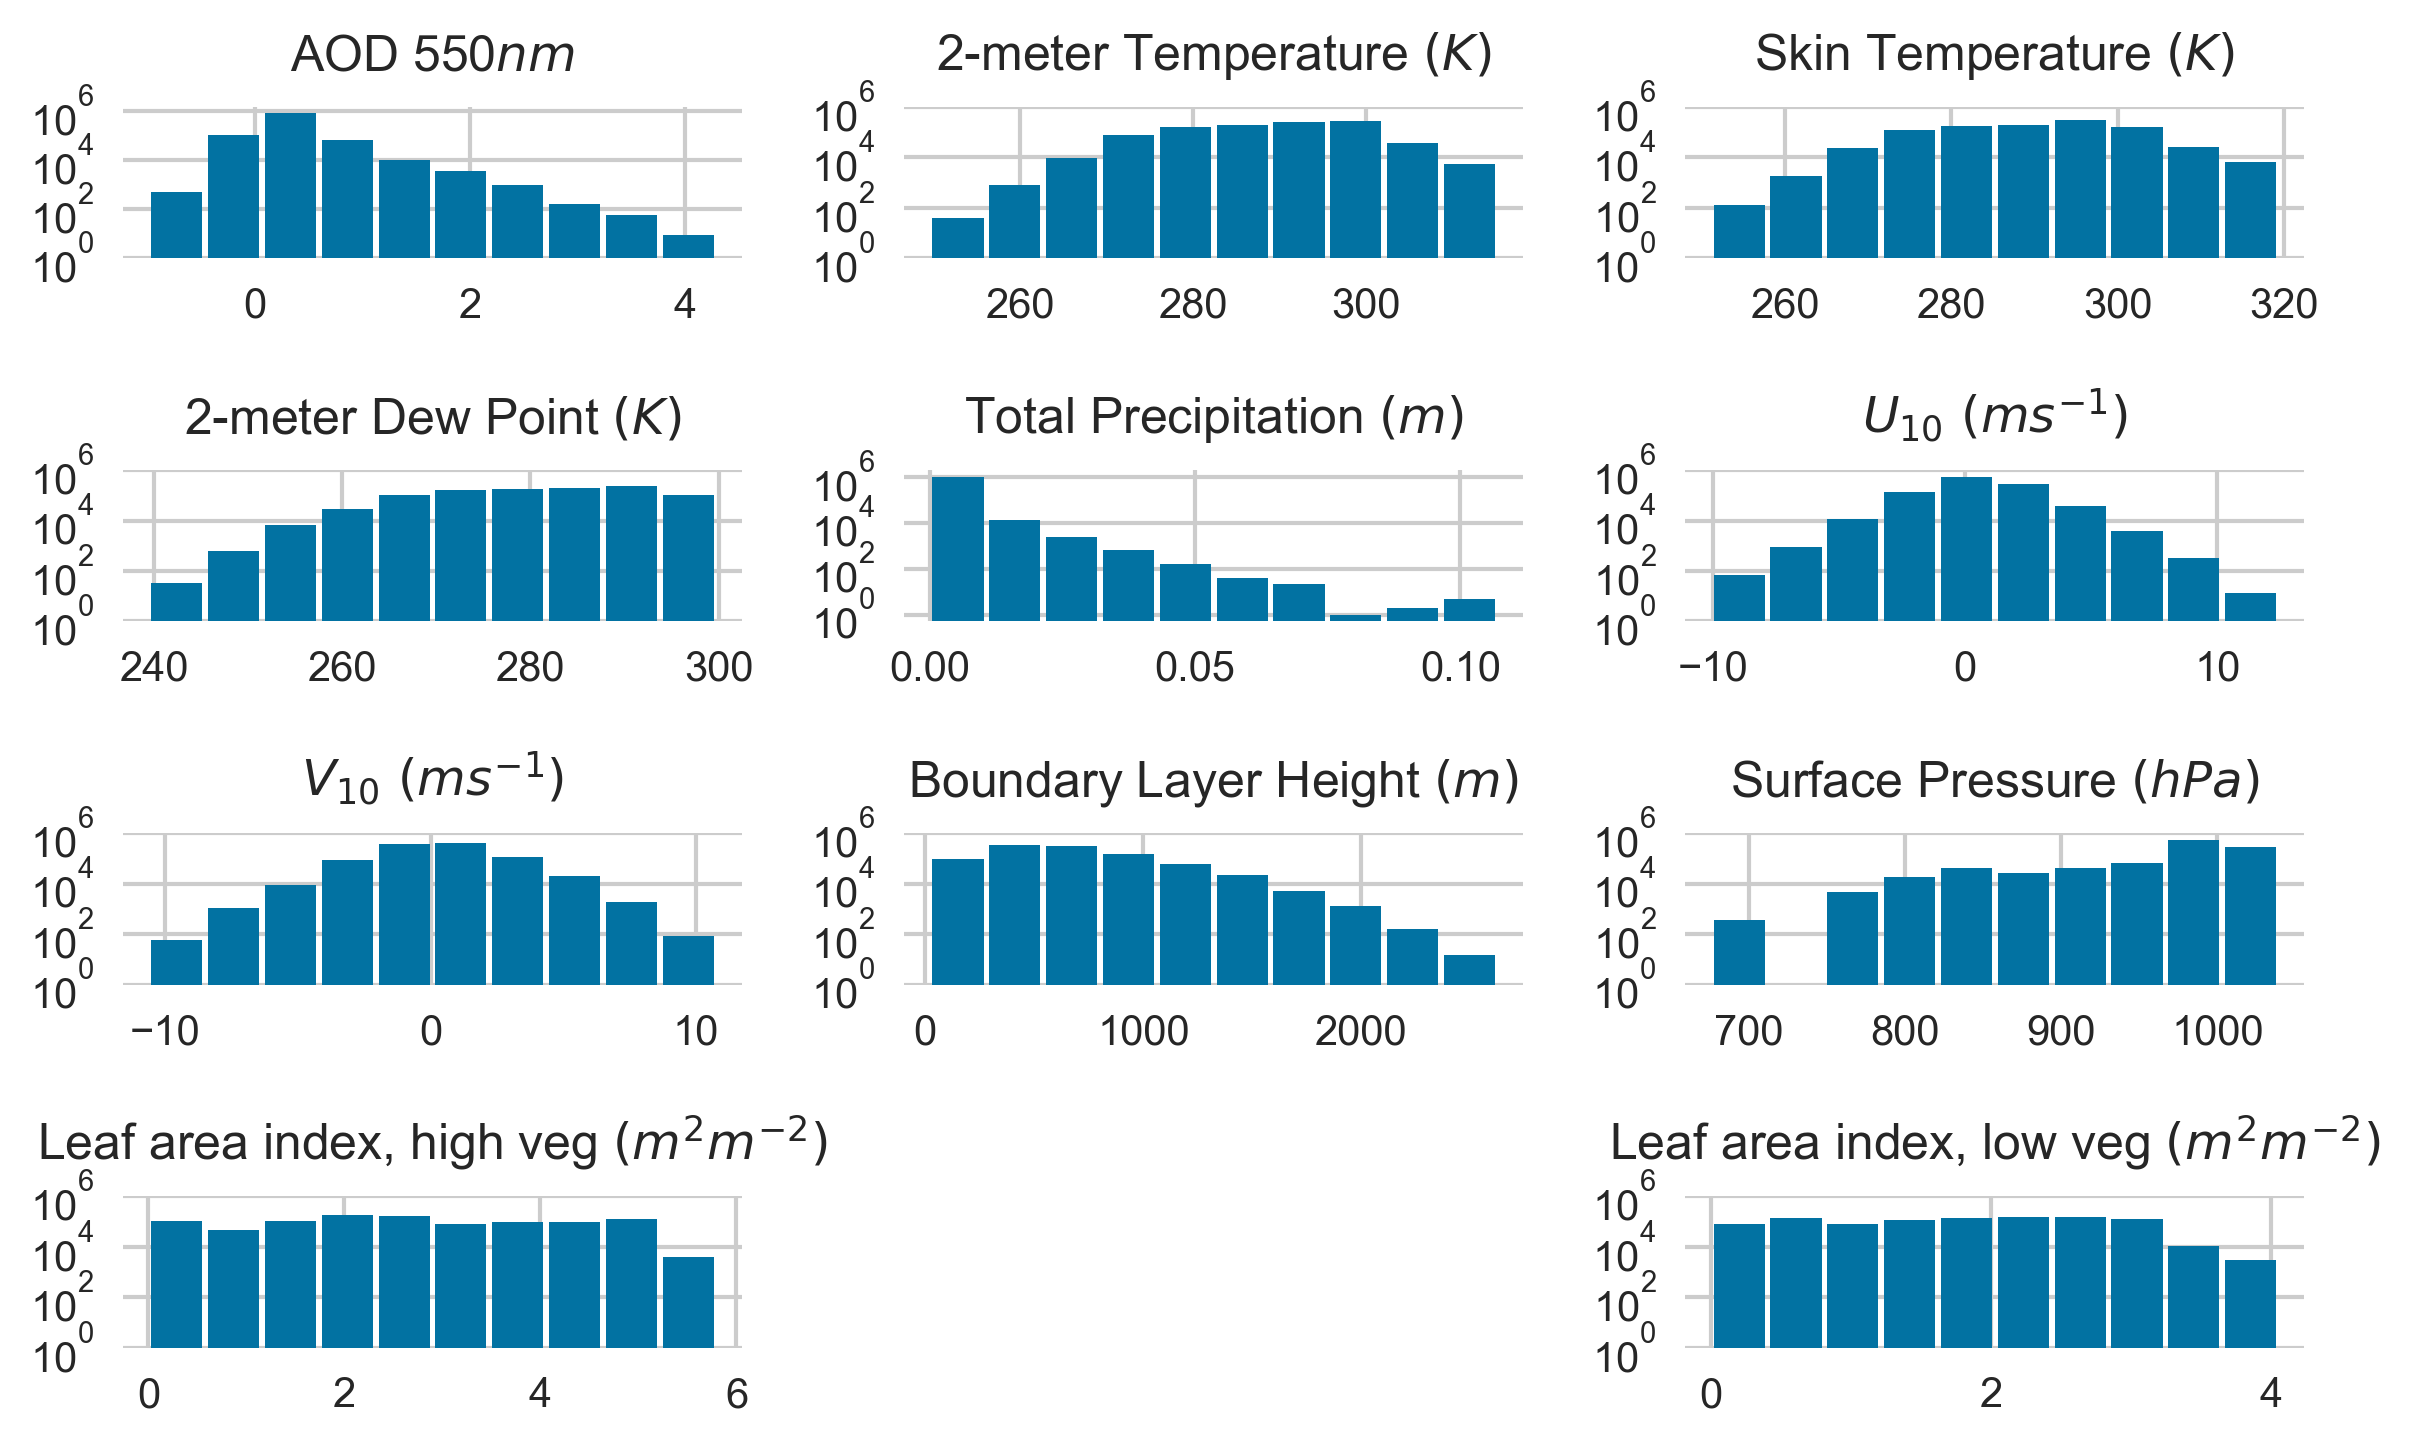

In [41]:
fig, axes = plt.subplots(4, 3, dpi=300, figsize=(8,5))

theax = np.array(axes.flatten()[:10].tolist() + axes.flatten().tolist()[11:12])

data.hist(ax=theax, rwidth=0.9)

no_spine = lambda ax: ax.spines[:].set_visible(False)
log = lambda ax: ax.set_yscale('log')
labels = lambda ax: ax.set_yticks(np.geomspace(1, 1e6, 4))
title = lambda ax: ax.set_title(ax.get_title(), y=1.08)
list(map(no_spine, axes.ravel()));
list(map(log, axes.ravel()))
list(map(title, axes.ravel()))
list(map(labels, axes.ravel()))

axes[3][1].set_visible(False)

fig.tight_layout()

# fig.savefig(f'{save_path}/feature_histograms.png', format='png', bbox_inches = "tight")

In [38]:
axes[0][0].get_title()

'AOD 550$nm$'

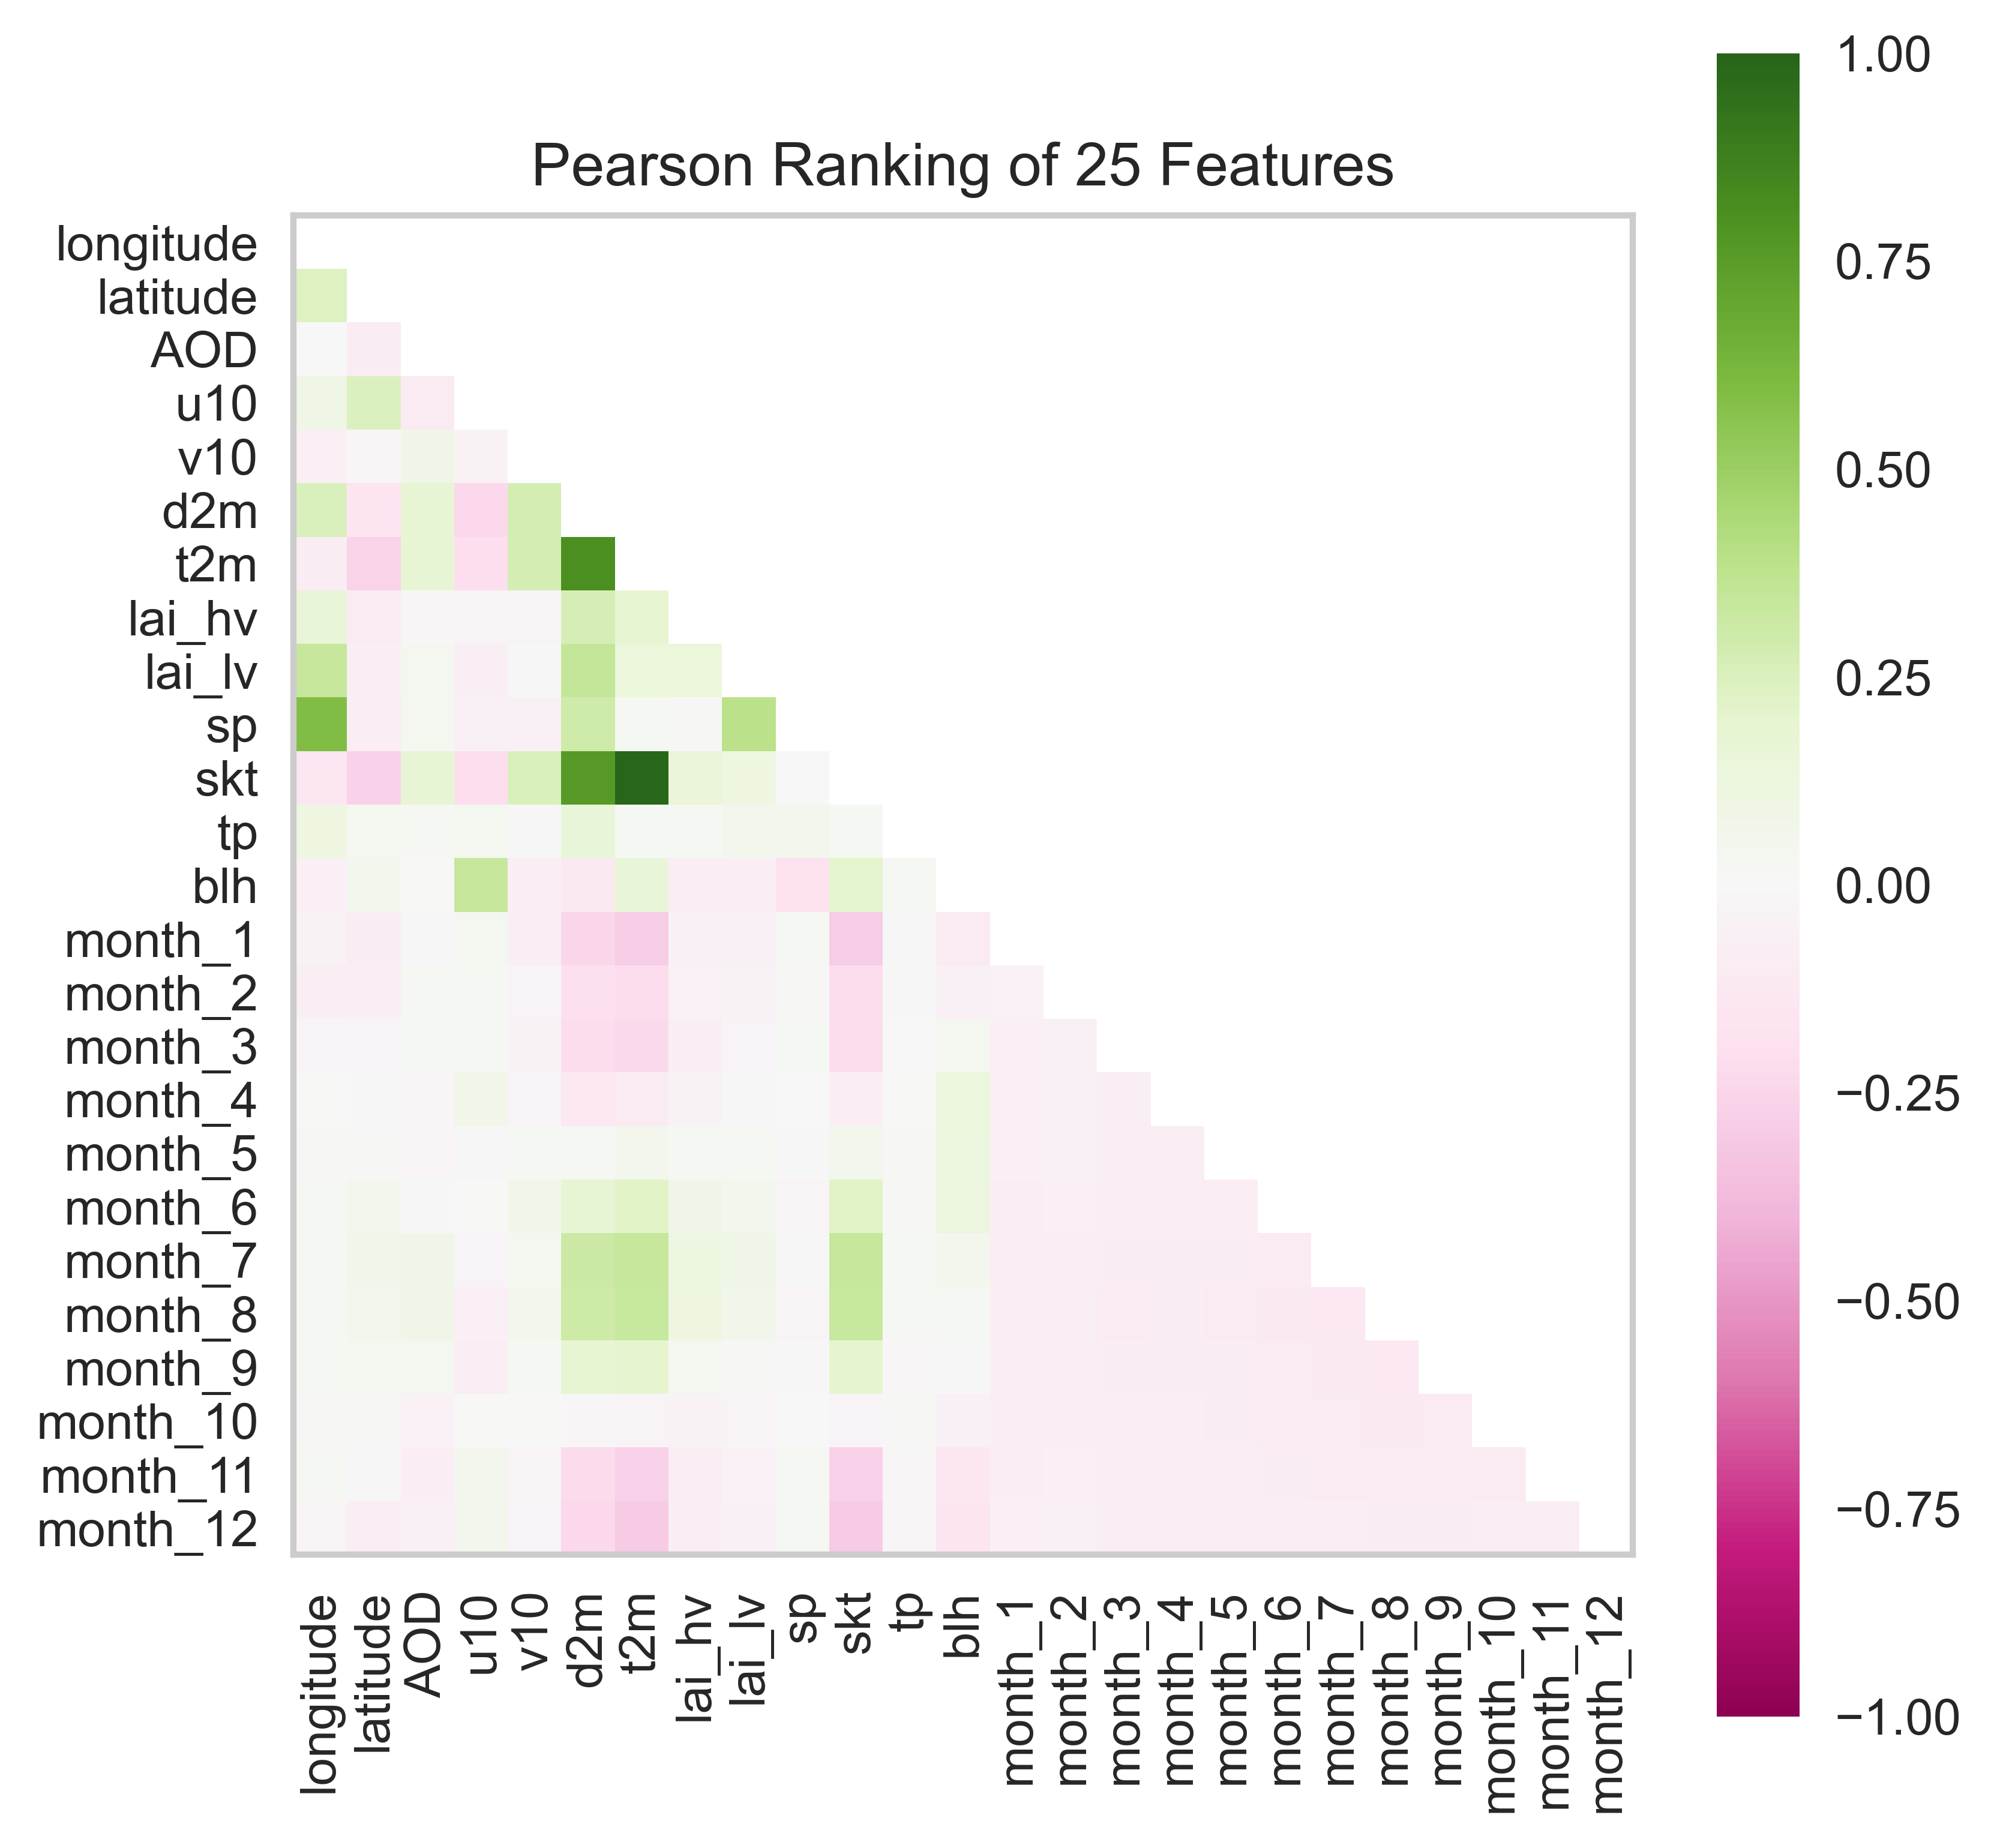

In [26]:
from yellowbrick.features import Rank2D

X = df.drop(columns=['value', 'time'], axis=1)

fig, ax = plt.subplots(figsize=(6, 6), dpi=600)

visualizer = Rank2D(algorithm='pearson', ax=ax, colormap='PiYG')
visualizer.fit(X)
visualizer.transform(X)

ax.tick_params(axis='both', which='major')

visualizer.show();

# fig.savefig(os.path.join(paths.figures, 'pearson-ranking.png'))

# Locations that were excluded when met and AOD were matched

In [46]:
df = pd.read_csv('data/matched/locations_with_nans.csv')

In [47]:
locations = df[['longitude', 'latitude']].drop_duplicates().reset_index(drop=True)

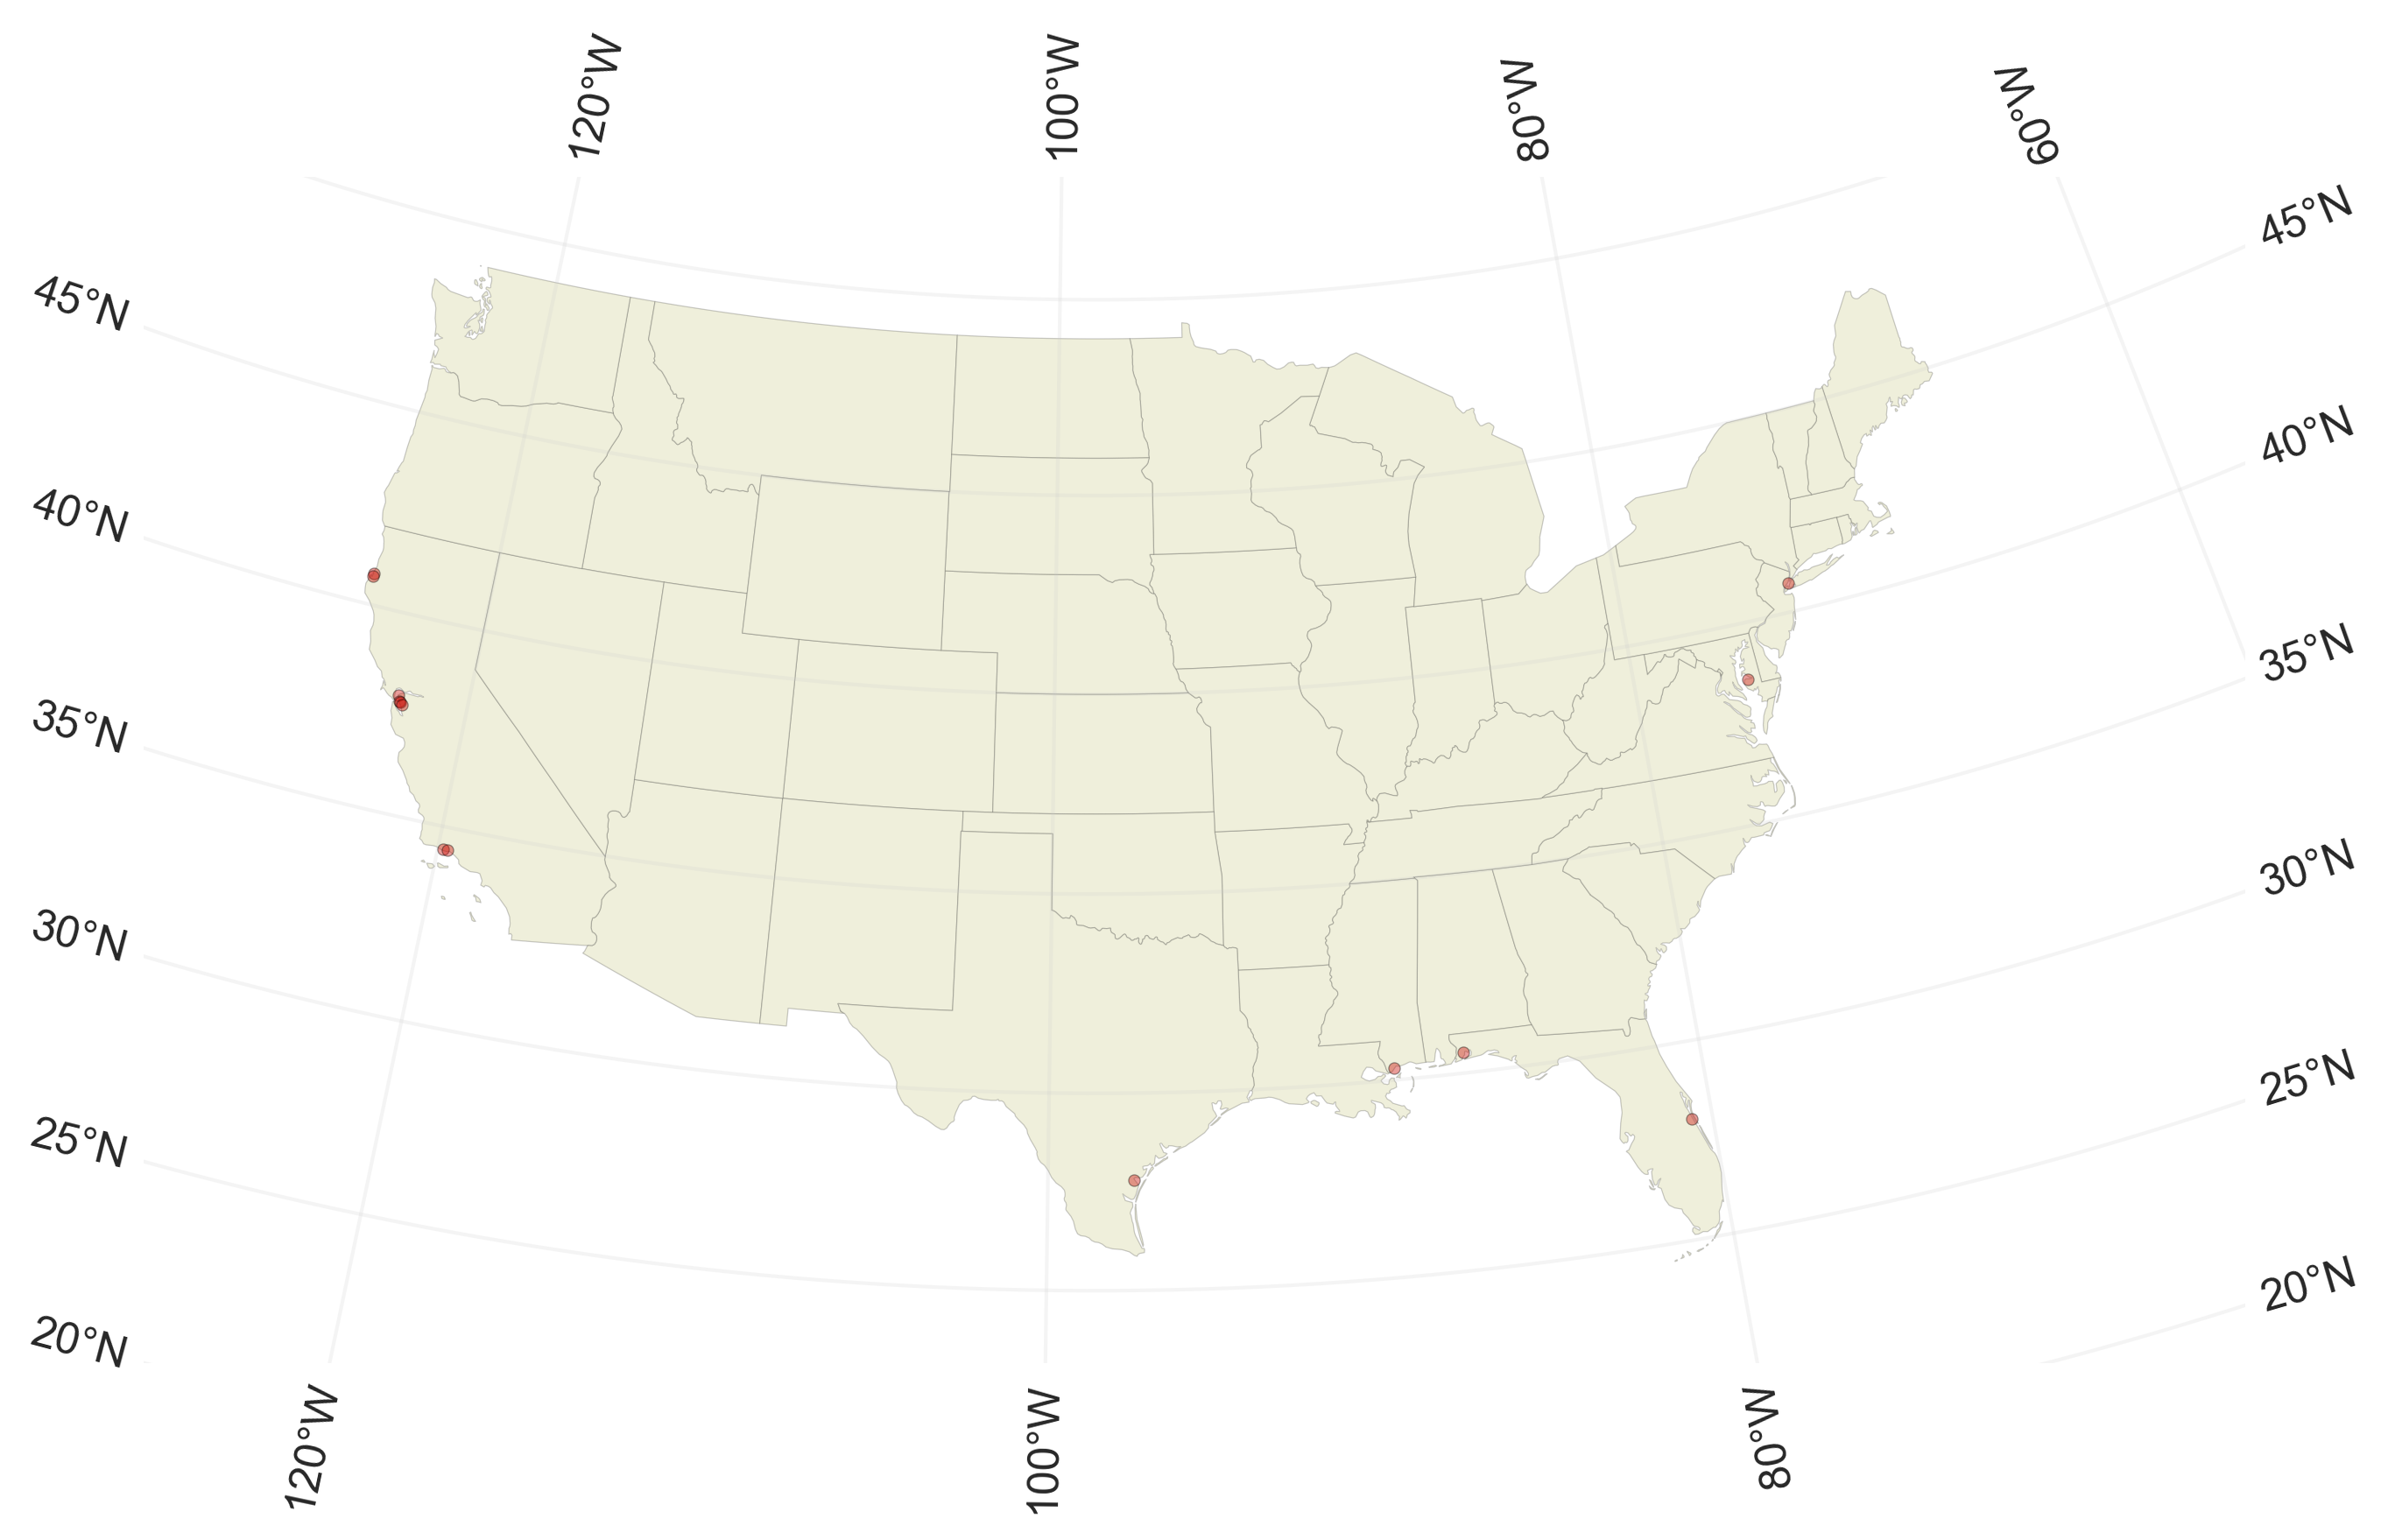

In [48]:
fig = plt.figure(dpi=300)
ax = fig.add_axes([0, 0, 1, 1], projection=equal_area, frameon=False)

ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())

def colorize_state(geometry):
    facecolor = (0.9375, 0.9375, 0.859375)
    return {'facecolor': facecolor, 'edgecolor': '#00000033'}

ax.add_geometries(
    contiguous_us.geometry,
    ccrs.PlateCarree(),
    styler=colorize_state)


ax.scatter(locations.longitude, locations.latitude,
       s=10, 
       alpha=0.4, 
       c='r',
       edgecolor='black',
       transform=ccrs.PlateCarree(), 
       zorder=10);

ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, alpha=0.2)

# Speciation

In [3]:
species = pd.read_csv('data/daily_SPEC_2022 2.csv')
pc = pd.read_csv('data/methods_speciation.csv')

In [12]:
pcodes = species[['Parameter Code']].drop_duplicates()

In [8]:
pc = pc[['Parameter', 'Parameter Code']]

In [16]:
speciation = pd.merge(pcodes, pc, on = 'Parameter Code', how='inner').drop_duplicates()

In [21]:
pm25_spec = speciation[speciation['Parameter'].str.contains('PM2.5')]

In [22]:
pm25_spec

Parameter Code                           Parameter
63            88102                   Antimony PM2.5 LC
76            88103                    Arsenic PM2.5 LC
95            88104                   Aluminum PM2.5 LC
109           88107                     Barium PM2.5 LC
119           88109                    Bromine PM2.5 LC
132           88111                    Calcium PM2.5 LC
145           88112                   Chromium PM2.5 LC
163           88113                     Cobalt PM2.5 LC
176           88114                     Copper PM2.5 LC
189           88115                   Chlorine PM2.5 LC
201           88126                       Iron PM2.5 LC
214           88128                       Lead PM2.5 LC
232           88132                  Manganese PM2.5 LC
250           88134                 Molybdenum PM2.5 LC
262           88136                     Nickel PM2.5 LC
279           88142                    Mercury PM2.5 LC
291           88152                 Phosphorus PM2.5 LC
303           88154                   Selenium PM2.5 LC
321           88160                        Tin PM2.5 LC
330           88161                   Titanium PM2.5 LC
343           88164                   Vanadium PM2.5 LC
357           88165                    Silicon PM2.5 LC
369           88167                       Zinc PM2.5 LC
382           88168                  Strontium PM2.5 LC
395           88169                     Sulfur PM2.5 LC
407           88176                   Rubidium PM2.5 LC
420           88180                  Potassium PM2.5 LC
440           88183                    Yttrium PM2.5 LC
448           88301               Ammonium Ion PM2.5 LC
473           88303              Potassium Ion PM2.5 LC
483           88306              Total Nitrate PM2.5 LC
499           88355  OC CSN_Rev Unadjusted PM2.5 LC TOT
505           88357  EC CSN_Rev Unadjusted PM2.5 LC TOT
511           88370  OC CSN_Rev Unadjusted PM2.5 LC TOR
516           88374     OC1 CSN_Rev Unadjusted PM2.5 LC
522           88375     OC2 CSN_Rev Unadjusted PM2.5 LC
528           88376     OC3 CSN_Rev Unadjusted PM2.5 LC
534           88377     OC4 CSN_Rev Unadjusted PM2.5 LC
540           88378  OP CSN_Rev Unadjusted PM2.5 LC TOR
546           88380  EC CSN_Rev Unadjusted PM2.5 LC TOR
553           88383     EC1 CSN_Rev Unadjusted PM2.5 LC
559           88384     EC2 CSN_Rev Unadjusted PM2.5 LC
565           88385     EC3 CSN_Rev Unadjusted PM2.5 LC
571           88388  OP CSN_Rev Unadjusted PM2.5 LC TOT
577           88403                    Sulfate PM2.5 LC
648           88313        Black Carbon PM2.5 at 880 nm
664           88314           UV Carbon PM2.5 at 370 nm
778           88305      OC CSN Unadjusted PM2.5 LC TOT
789           88307                 EC CSN PM2.5 LC TOT
800           88312           Total Carbon PM2.5 LC TOT